In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# Imports
from datetime import date
from itertools import product
from pprint import pprint

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit

from vaxflux.covariates import (
    CovariateCategories,
    GaussianRandomWalkCovariate,
    PooledCovariate,
)
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.data import sample_dataset
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

In [2]:
true_epsilon = 0.0005
conf_interval = 0.98
conf_lower = (1.0 - conf_interval) / 2.0
conf_higher = 1.0 - conf_lower

In [3]:
logistic_curve = LogisticIncidenceCurve()
logistic_curve

In [4]:
logistic_curve.parameters

('m', 'r', 's')

In [5]:
range_days = 6
season_ranges = [
    SeasonRange(
        season="2022/23", start_date=date(2022, 9, 5), end_date=date(2023, 1, 29)
    ),
    SeasonRange(
        season="2023/24", start_date=date(2023, 9, 4), end_date=date(2024, 1, 28)
    ),
    SeasonRange(
        season="2024/25", start_date=date(2024, 9, 2), end_date=date(2025, 1, 26)
    ),
]
date_ranges = daily_date_ranges(season_ranges, range_days=range_days)

In [6]:
sex_cov = CovariateCategories(covariate="sex", categories=("female", "male"))
age_cov = CovariateCategories(
    covariate="age", categories=("adult", "senior", "elderly")
)

In [7]:
params = []

params_grid = {
    "2022/23": {
        "m": -0.5,
        "r": -3.2,
        "s": 40.0,
        "male": {
            "m": -0.05,
        },
        "senior": {
            "m": 1.0,
        },
        "elderly": {
            "m": 1.8,
        },
    },
    "2023/24": {
        "m": -0.55,
        "r": -3.1,
        "s": 42.5,
        "male": {
            "m": -0.06,
        },
        "senior": {
            "m": 1.05,
        },
        "elderly": {
            "m": 1.75,
        },
    },
    "2024/25": {
        "m": -0.51,
        "r": -3.3,
        "s": 41.0,
        "male": {
            "m": -0.04,
        },
        "senior": {
            "m": 1.1,
        },
        "elderly": {
            "m": 1.85,
        },
    },
}

for curve_param in logistic_curve.parameters:
    for season_range in season_ranges:
        for sex_category in sex_cov.categories:
            for age_category in age_cov.categories:
                season_params = params_grid[season_range.season]
                param_value = (
                    season_params[curve_param]
                    + season_params.get(sex_category, {}).get(curve_param, 0)
                    + season_params.get(age_category, {}).get(curve_param, 0)
                )
                params.append(
                    (
                        curve_param,
                        season_range.season,
                        sex_category,
                        age_category,
                        param_value,
                    )
                )

pprint(params)

[('m', '2022/23', 'female', 'adult', -0.5),
 ('m', '2022/23', 'female', 'senior', 0.5),
 ('m', '2022/23', 'female', 'elderly', 1.3),
 ('m', '2022/23', 'male', 'adult', -0.55),
 ('m', '2022/23', 'male', 'senior', 0.44999999999999996),
 ('m', '2022/23', 'male', 'elderly', 1.25),
 ('m', '2023/24', 'female', 'adult', -0.55),
 ('m', '2023/24', 'female', 'senior', 0.5),
 ('m', '2023/24', 'female', 'elderly', 1.2),
 ('m', '2023/24', 'male', 'adult', -0.6100000000000001),
 ('m', '2023/24', 'male', 'senior', 0.43999999999999995),
 ('m', '2023/24', 'male', 'elderly', 1.14),
 ('m', '2024/25', 'female', 'adult', -0.51),
 ('m', '2024/25', 'female', 'senior', 0.5900000000000001),
 ('m', '2024/25', 'female', 'elderly', 1.34),
 ('m', '2024/25', 'male', 'adult', -0.55),
 ('m', '2024/25', 'male', 'senior', 0.55),
 ('m', '2024/25', 'male', 'elderly', 1.3),
 ('r', '2022/23', 'female', 'adult', -3.2),
 ('r', '2022/23', 'female', 'senior', -3.2),
 ('r', '2022/23', 'female', 'elderly', -3.2),
 ('r', '2022/23

In [8]:
observations = sample_dataset(
    logistic_curve, season_ranges, date_ranges, [sex_cov, age_cov], params, true_epsilon
)
observations

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value
0,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,adult,incidence,0.016363
1,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,senior,incidence,0.025353
2,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,elderly,incidence,0.033812
3,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,male,adult,incidence,0.014335
4,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,male,senior,incidence,0.025144
...,...,...,...,...,...,...,...,...,...,...
373,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,female,senior,incidence,0.004505
374,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,female,elderly,incidence,0.004074
375,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,male,adult,incidence,0.001648
376,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,male,senior,incidence,0.002680


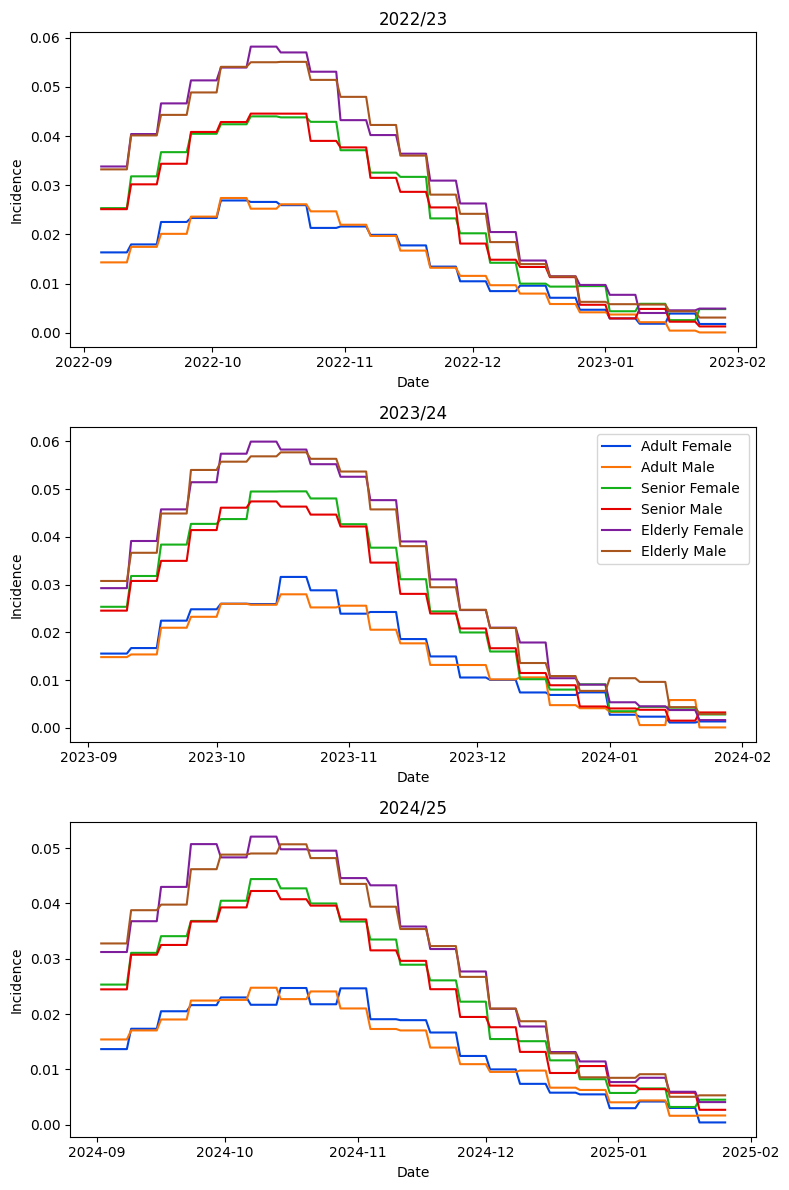

In [9]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=colors_map.get(hash((age_category, sex_category))),
            )
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [10]:
observations_prevalence = observations.copy()
observations_prevalence = observations_prevalence.sort_values(
    [
        "start_date",
        "end_date",
        "season",
        "season_start_date",
        "season_end_date",
        "sex",
        "age",
    ]
).reset_index(drop=True)
observations_prevalence["prevalence"] = (
    observations_prevalence.groupby(["season", "sex", "age"])["value"]
    .cumsum()
    .reset_index()["value"]
)
observations_prevalence

,season,season_start_date,season_end_date,start_date,end_date,report_date,sex,age,type,value,prevalence
0,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,adult,incidence,0.016363,0.016363
1,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,elderly,incidence,0.033812,0.033812
2,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,female,senior,incidence,0.025353,0.025353
3,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,male,adult,incidence,0.014335,0.014335
4,2022/23,2022-09-05,2023-01-29,2022-09-05,2022-09-11,2022-09-11,male,elderly,incidence,0.033227,0.033227
...,...,...,...,...,...,...,...,...,...,...,...
373,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,female,elderly,incidence,0.004074,0.634107
374,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,female,senior,incidence,0.004505,0.512773
375,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,male,adult,incidence,0.001648,0.292105
376,2024/25,2024-09-02,2025-01-26,2025-01-20,2025-01-26,2025-01-26,male,elderly,incidence,0.005296,0.620711


In [11]:
prevalence_offsets = {}
for season_range in season_ranges:
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            season_params = params_grid[season_range.season]
            kwargs = {}
            for param in logistic_curve.parameters:
                kwargs[param] = (
                    season_params[param]
                    + season_params.get(sex_category, {}).get(param, 0)
                    + season_params.get(age_category, {}).get(param, 0)
                )
            print(kwargs)
            prevalence_offsets[
                hash((season_range.season, age_category, sex_category))
            ] = logistic_curve.prevalence(0.0, **kwargs).eval()

{'m': -0.5, 'r': -3.2, 's': 40.0}
{'m': -0.55, 'r': -3.2, 's': 40.0}
{'m': 0.5, 'r': -3.2, 's': 40.0}
{'m': 0.44999999999999996, 'r': -3.2, 's': 40.0}
{'m': 1.3, 'r': -3.2, 's': 40.0}
{'m': 1.25, 'r': -3.2, 's': 40.0}
{'m': -0.55, 'r': -3.1, 's': 42.5}
{'m': -0.6100000000000001, 'r': -3.1, 's': 42.5}
{'m': 0.5, 'r': -3.1, 's': 42.5}
{'m': 0.43999999999999995, 'r': -3.1, 's': 42.5}
{'m': 1.2, 'r': -3.1, 's': 42.5}
{'m': 1.14, 'r': -3.1, 's': 42.5}
{'m': -0.51, 'r': -3.3, 's': 41.0}
{'m': -0.55, 'r': -3.3, 's': 41.0}
{'m': 0.5900000000000001, 'r': -3.3, 's': 41.0}
{'m': 0.55, 'r': -3.3, 's': 41.0}
{'m': 1.34, 'r': -3.3, 's': 41.0}
{'m': 1.3, 'r': -3.3, 's': 41.0}


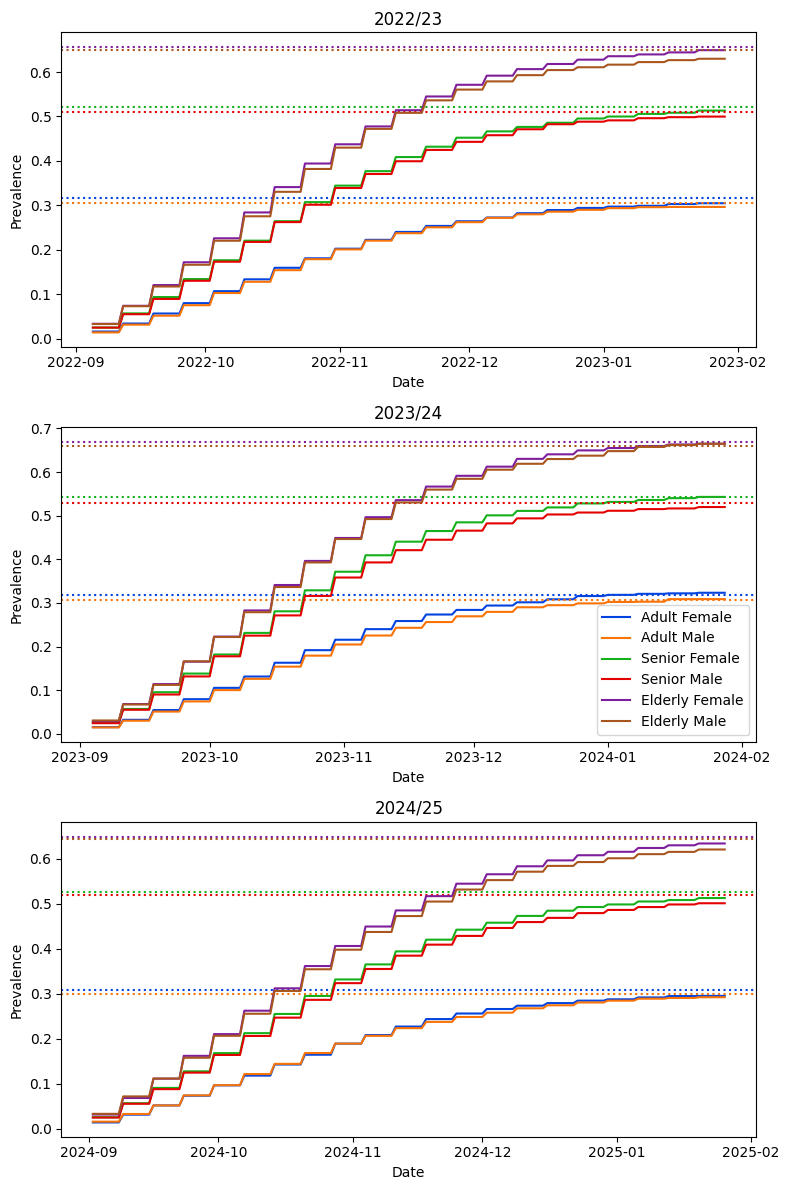

In [12]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Prevalence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=colors_map.get(hash((age_category, sex_category))),
            )
            ax.axhline(
                y=expit(
                    params_grid[season_range.season]["m"]
                    + params_grid[season_range.season]
                    .get(age_category, {})
                    .get("m", 0.0)
                    + params_grid[season_range.season]
                    .get(sex_category, {})
                    .get("m", 0.0)
                )
                - prevalence_offsets[
                    hash((season_range.season, age_category, sex_category))
                ],
                linestyle=":",
                color=colors_map.get(hash((age_category, sex_category))),
            )
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [ ]:
model = SeasonalUptakeModel(
    logistic_curve,
    [
        PooledCovariate(
            parameter="m",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -0.5, "sigma": 0.25},
        ),
        PooledCovariate(
            parameter="r",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": -3.0, "sigma": 0.5},
        ),
        PooledCovariate(
            parameter="s",
            covariate=None,
            distribution="Normal",
            distribution_kwargs={"mu": 40.0, "sigma": 5.0},
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="age",
            init_mu=[1.0, 2.0],
            mu=2 * [0.0],
            sigma=2 * [0.25],
            eta=2.0,
        ),
        GaussianRandomWalkCovariate(
            parameter="m",
            covariate="sex",
            init_mu=-0.5,
            mu=0.0,
            sigma=0.1,
        ),
    ],
    covariate_categories=[sex_cov, age_cov],
    season_ranges=season_ranges,
    date_ranges=date_ranges,
    epsilon=0.001,
    # Custom keyword arguments
    constrain_prevalence=False,
    observation_sigma=1e-5,
    pooled_epsilon=True,
)
model

---

In [ ]:
model_full_observations = model.add_observations(observations)

In [ ]:
model_full_observations.build(debug=False)

In [ ]:
model_full_observations.sample(
    tune=3000,
    draws=1000,
    chains=4,
)

Running window adaptation


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


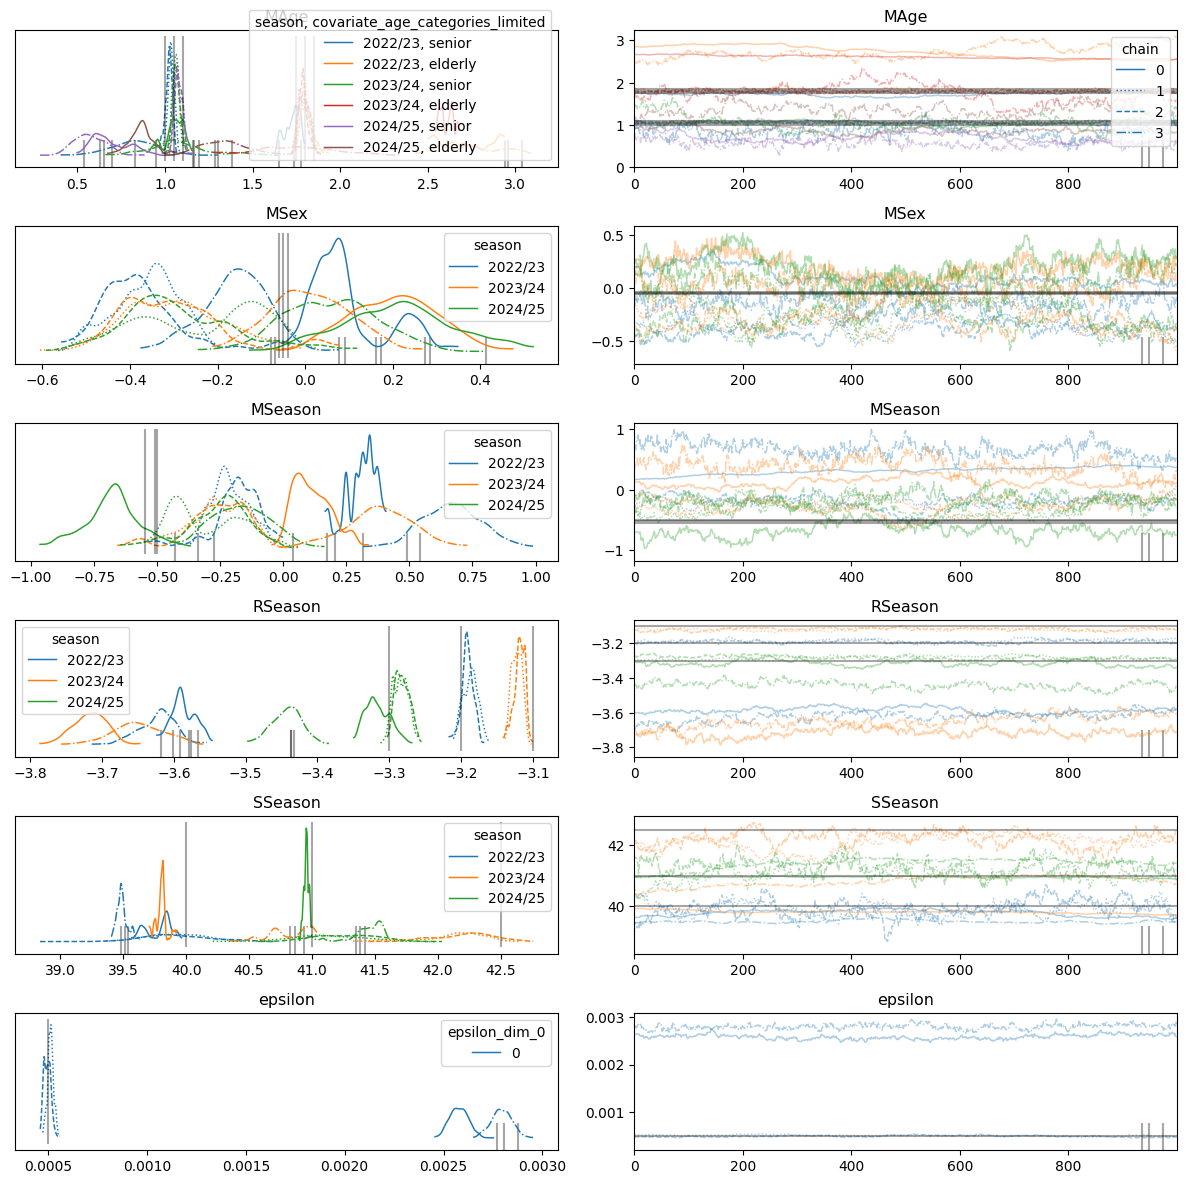

In [ ]:
az.plot_trace(
    model_full_observations._trace,
    var_names=["MAge", "MSex", "MSeason", "RSeason", "SSeason", "epsilon"],
    lines=[
        (
            "MAge",
            {},
            [
                params_grid[season.season][age]["m"]
                for season in season_ranges
                for age in age_cov.categories[1:]
            ],
        ),
        (
            "MSex",
            {},
            [params_grid[season.season]["male"]["m"] for season in season_ranges],
        ),
        ("MSeason", {}, [params_grid[season.season]["m"] for season in season_ranges]),
        ("RSeason", {}, [params_grid[season.season]["r"] for season in season_ranges]),
        ("SSeason", {}, [params_grid[season.season]["s"] for season in season_ranges]),
        ("epsilon", {}, [true_epsilon]),
    ],
    legend=True,
    compact=True,
)
plt.tight_layout()

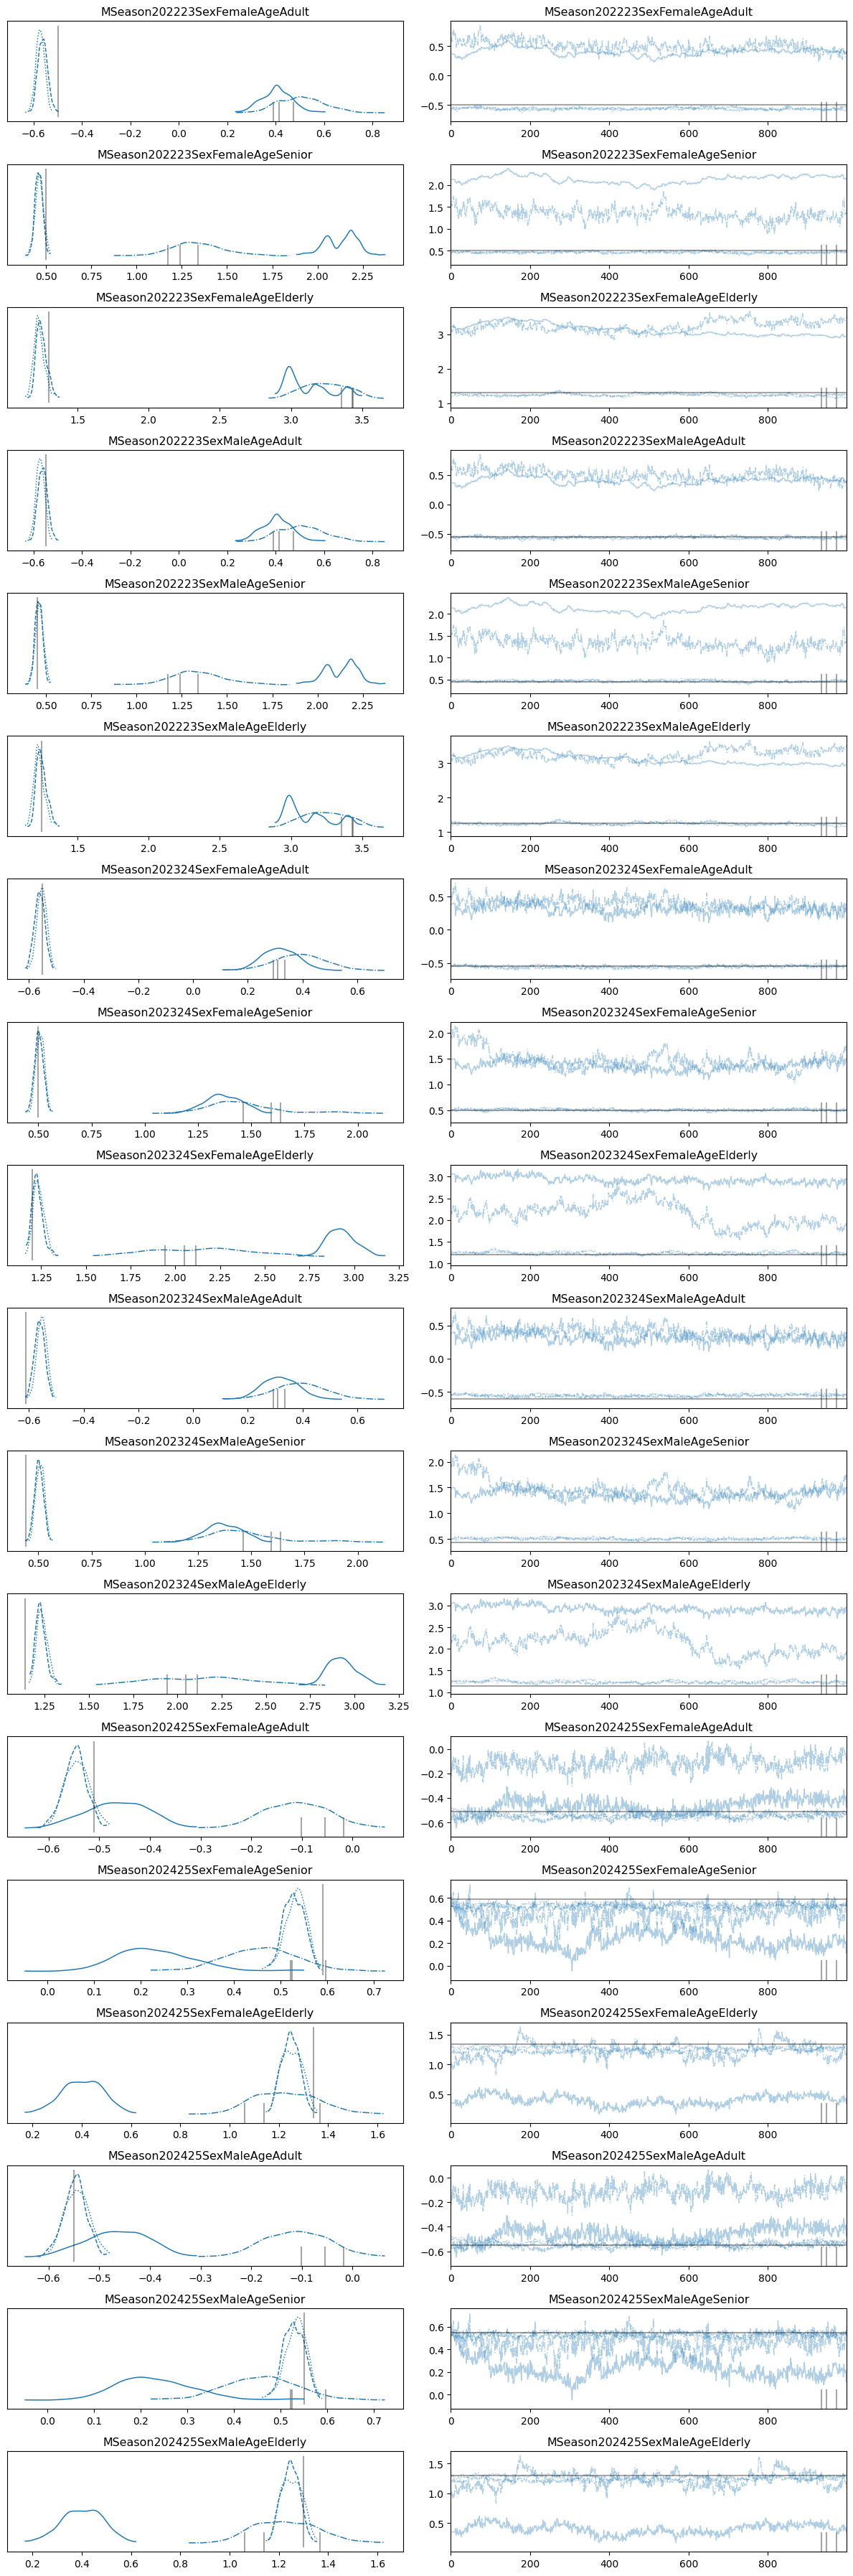

In [ ]:
var_names_and_lines = {
    (
        f"{p[0].title()}Season{p[1].replace('/', '').title()}"
        f"Sex{p[2].title()}Age{p[3].title()}"
    ): p[4]
    for p in params
    if p[0] == "m"
}

az.plot_trace(
    model_full_observations._trace,
    var_names=list(var_names_and_lines.keys()),
    lines=[(k, {}, v) for k, v in var_names_and_lines.items()],
)
plt.tight_layout()

In [ ]:
posterior_df = model_full_observations.dataframe()
posterior_df.head(10)

,draw,chain,season,date,sex,age,type,value
0,0,0,2022/23,2022-09-05,female,adult,incidence,0.001842
1,0,0,2022/23,2022-09-06,female,adult,incidence,0.002370
2,0,0,2022/23,2022-09-07,female,adult,incidence,0.003147
3,0,0,2022/23,2022-09-08,female,adult,incidence,0.001859
4,0,0,2022/23,2022-09-09,female,adult,incidence,0.002790
5,0,0,2022/23,2022-09-10,female,adult,incidence,0.002510
6,0,0,2022/23,2022-09-11,female,adult,incidence,0.001846
7,0,0,2022/23,2022-09-12,female,adult,incidence,0.002204
8,0,0,2022/23,2022-09-13,female,adult,incidence,0.004473
9,0,0,2022/23,2022-09-14,female,adult,incidence,0.001607


In [36]:
posterior_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10584000 entries, 0 to 587999
Data columns (total 8 columns):
 #   Column  Dtype         
---  ------  -----         
 0   draw    int64         
 1   chain   int64         
 2   season  string        
 3   date    datetime64[ns]
 4   sex     string        
 5   age     string        
 6   type    string        
 7   value   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(4)
memory usage: 726.7 MB


In [37]:
draws_max = 50
chains_and_draws = (
    posterior_df[["chain", "draw"]].drop_duplicates().reset_index(drop=True)
)
chains_and_draws = chains_and_draws[chains_and_draws["draw"] <= draws_max]
chains_and_draws

,chain,draw
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4
...,...,...
3046,3,46
3047,3,47
3048,3,48
3049,3,49


In [38]:
posterior_df_with_index = posterior_df.set_index(
    keys=["chain", "draw", "season", "sex", "age"]
)
posterior_df_with_index = posterior_df_with_index.query("draw <= @draws_max")
posterior_df_with_index

date       type     value
chain draw season  sex    age                                    
0     0    2022/23 female adult   2022-09-05  incidence  0.001842
                          adult   2022-09-06  incidence  0.002370
                          adult   2022-09-07  incidence  0.003147
                          adult   2022-09-08  incidence  0.001859
                          adult   2022-09-09  incidence  0.002790
...                                      ...        ...       ...
3     50   2024/25 male   elderly 2025-01-22  incidence  0.000003
                          elderly 2025-01-23  incidence  0.000002
                          elderly 2025-01-24  incidence  0.000002
                          elderly 2025-01-25  incidence  0.000005
                          elderly 2025-01-26  incidence  0.000008

[539784 rows x 3 columns]

/var/folders/2z/h3pc0p7s3ng1tvxrgsw5kr680000gp/T/ipykernel_77654/1681434139.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


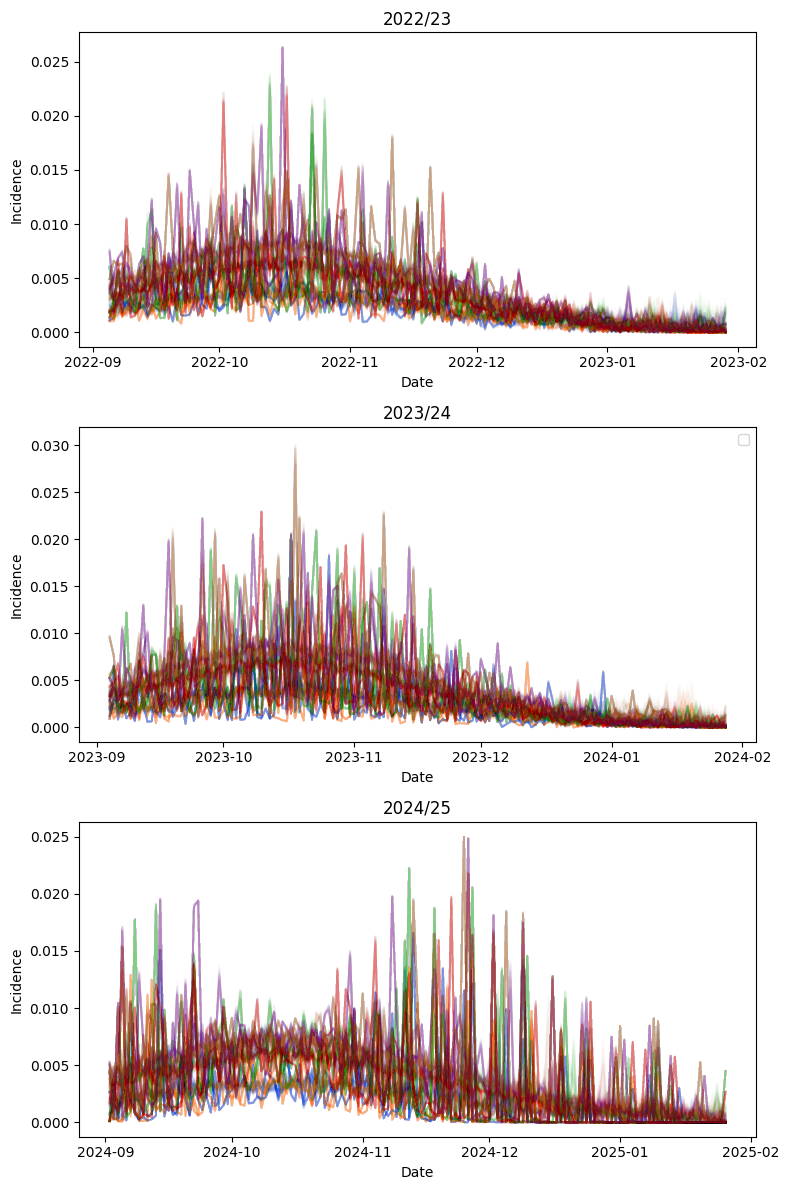

In [39]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")

    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            for row in chains_and_draws.itertuples():
                posterior_subset = posterior_df_with_index.query(
                    f"chain == {row.chain} and draw == {row.draw} "
                    f"and season == '{season_range.season}' "
                    f"and sex == '{sex_category}' and age == '{age_category}'"
                ).copy()
                ax.plot(
                    posterior_subset["date"].tolist(),
                    posterior_subset["value"].tolist(),
                    color=color,
                    linestyle="-",
                    alpha=0.01,
                )
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [24]:
posterior_df = (
    posterior_df.drop(columns=["type"])
    .rename(columns={"value": "incidence"})
    .sort_values(["draw", "chain", "season", "sex", "age", "date"])
    .reset_index(drop=True)
)
posterior_df["prevalence"] = (
    posterior_df.groupby(["draw", "chain", "season", "sex", "age"])["incidence"]
    .cumsum()
    .reset_index()["incidence"]
)
posterior_df

,draw,chain,season,date,sex,age,incidence,prevalence
0,0,0,2022/23,2022-09-05,female,adult,1.841669e-03,0.001842
1,0,0,2022/23,2022-09-06,female,adult,2.370023e-03,0.004212
2,0,0,2022/23,2022-09-07,female,adult,3.147036e-03,0.007359
3,0,0,2022/23,2022-09-08,female,adult,1.859286e-03,0.009218
4,0,0,2022/23,2022-09-09,female,adult,2.790351e-03,0.012008
...,...,...,...,...,...,...,...,...
10583995,999,3,2024/25,2025-01-22,male,senior,1.165672e-06,0.498445
10583996,999,3,2024/25,2025-01-23,male,senior,1.297854e-06,0.498446
10583997,999,3,2024/25,2025-01-24,male,senior,8.841615e-07,0.498447
10583998,999,3,2024/25,2025-01-25,male,senior,5.838450e-07,0.498448


In [25]:
range_days_to_freq = {
    6: "W",
}
if range_days > 0:
    if (freq := range_days_to_freq.get(range_days)) is None:
        raise RuntimeError(
            f"Range days {range_days} not supported, "
            f"please add to `range_days_to_freq` dictionary."
        )
    incidence_posterior_df = (
        posterior_df.groupby(
            ["chain", "draw", "season", pd.Grouper(key="date", freq=freq), "sex", "age"]
        )["incidence"]
        .sum()
        .reset_index()
    )
incidence_posterior_df = (
    incidence_posterior_df if range_days > 0 else posterior_df
).rename(columns={"date": "end_date"})
incidence_posterior_df["start_date"] = incidence_posterior_df[
    "end_date"
] - pd.Timedelta(days=range_days)
incidence_posterior_df = (
    incidence_posterior_df.groupby(["season", "start_date", "end_date", "sex", "age"])[
        "incidence"
    ]
    .agg(
        [
            lambda x: np.quantile(x, conf_lower),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, conf_higher),
        ]
    )
    .reset_index()
)
incidence_posterior_df = incidence_posterior_df.rename(
    columns={
        incidence_posterior_df.columns[-3]: "lower",
        incidence_posterior_df.columns[-2]: "median",
        incidence_posterior_df.columns[-1]: "upper",
    }
)
incidence_posterior_df

,season,start_date,end_date,sex,age,lower,median,upper
0,2022/23,2022-09-05,2022-09-11,female,adult,1.634000e-02,0.016363,0.016387
1,2022/23,2022-09-05,2022-09-11,female,elderly,3.379000e-02,0.033812,0.033835
2,2022/23,2022-09-05,2022-09-11,female,senior,2.532948e-02,0.025353,0.025378
3,2022/23,2022-09-05,2022-09-11,male,adult,1.431441e-02,0.014336,0.014357
4,2022/23,2022-09-05,2022-09-11,male,elderly,3.320450e-02,0.033228,0.033251
...,...,...,...,...,...,...,...,...
373,2024/25,2025-01-20,2025-01-26,female,elderly,9.955393e-07,0.004070,0.004096
374,2024/25,2025-01-20,2025-01-26,female,senior,5.003631e-07,0.004500,0.004526
375,2024/25,2025-01-20,2025-01-26,male,adult,1.613339e-07,0.001643,0.001671
376,2024/25,2025-01-20,2025-01-26,male,elderly,1.138204e-06,0.005291,0.005319


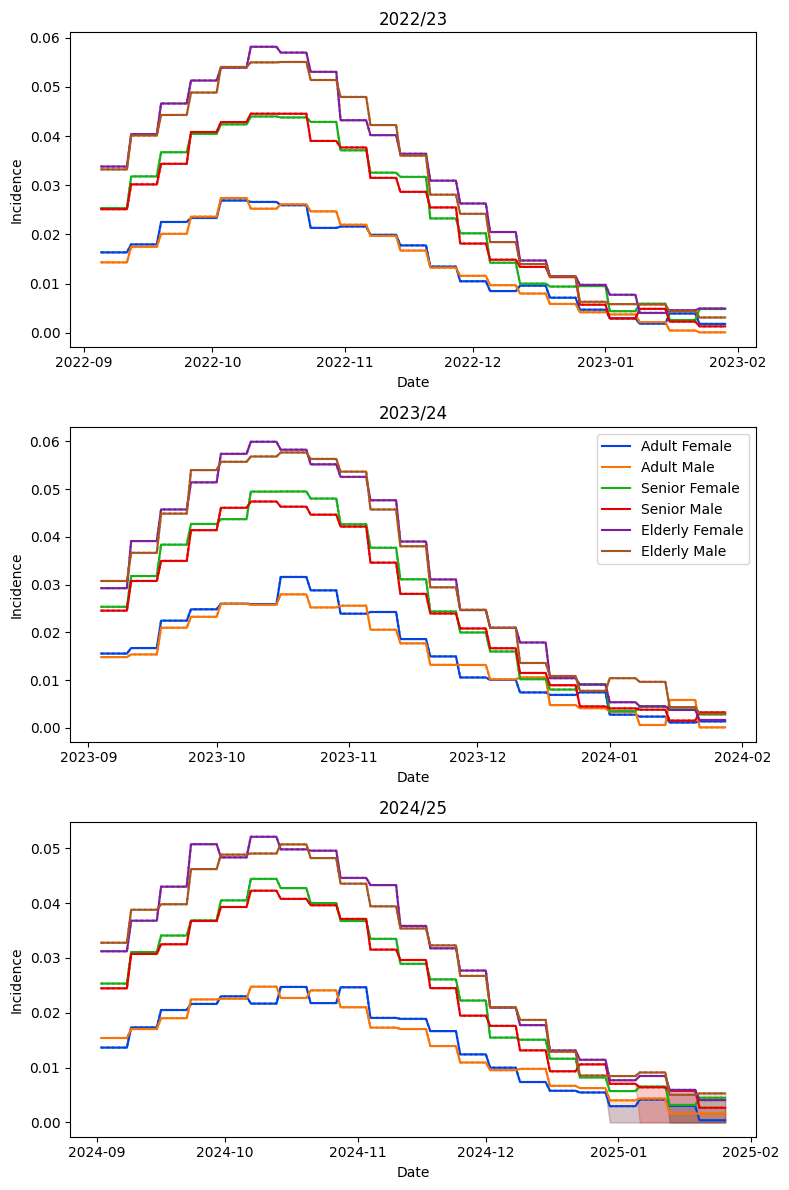

In [26]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations[
                (observations["season"] == season_range.season)
                & (observations["age"] == age_category)
                & (observations["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["value"].tolist(),
                    observations_subset["value"].tolist(),
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = incidence_posterior_df[
                (incidence_posterior_df["season"] == season_range.season)
                & (incidence_posterior_df["age"] == age_category)
                & (incidence_posterior_df["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    summary_posterior_subset["start_date"].tolist(),
                    summary_posterior_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    summary_posterior_subset["median"].tolist(),
                    summary_posterior_subset["median"].tolist(),
                )
                for el in pair
            ]
            ax.plot(x, y, color=color, linestyle=":")

            y1 = [
                el
                for pair in zip(
                    summary_posterior_subset["lower"].tolist(),
                    summary_posterior_subset["lower"].tolist(),
                )
                for el in pair
            ]
            y2 = [
                el
                for pair in zip(
                    summary_posterior_subset["upper"].tolist(),
                    summary_posterior_subset["upper"].tolist(),
                )
                for el in pair
            ]
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

In [27]:
prevalence_posterior_df = (
    posterior_df.groupby(["season", "date", "sex", "age"])["prevalence"]
    .agg(
        [
            lambda x: np.quantile(x, conf_lower),
            lambda x: np.quantile(x, 0.5),
            lambda x: np.quantile(x, conf_higher),
        ]
    )
    .reset_index()
)
prevalence_posterior_df = prevalence_posterior_df.rename(
    columns={
        prevalence_posterior_df.columns[-3]: "lower",
        prevalence_posterior_df.columns[-2]: "median",
        prevalence_posterior_df.columns[-1]: "upper",
    }
)
prevalence_posterior_df

,season,date,sex,age,lower,median,upper
0,2022/23,2022-09-05,female,adult,0.000664,0.001911,0.003165
1,2022/23,2022-09-05,female,elderly,0.002893,0.004396,0.009485
2,2022/23,2022-09-05,female,senior,0.001388,0.003283,0.006219
3,2022/23,2022-09-05,male,adult,0.001038,0.001702,0.002904
4,2022/23,2022-09-05,male,elderly,0.001509,0.004274,0.005211
...,...,...,...,...,...,...,...
2641,2024/25,2025-01-26,female,elderly,0.624028,0.634089,0.634211
2642,2024/25,2025-01-26,female,senior,0.505002,0.512754,0.512876
2643,2024/25,2025-01-26,male,adult,0.280392,0.292082,0.292207
2644,2024/25,2025-01-26,male,elderly,0.610315,0.620694,0.620809


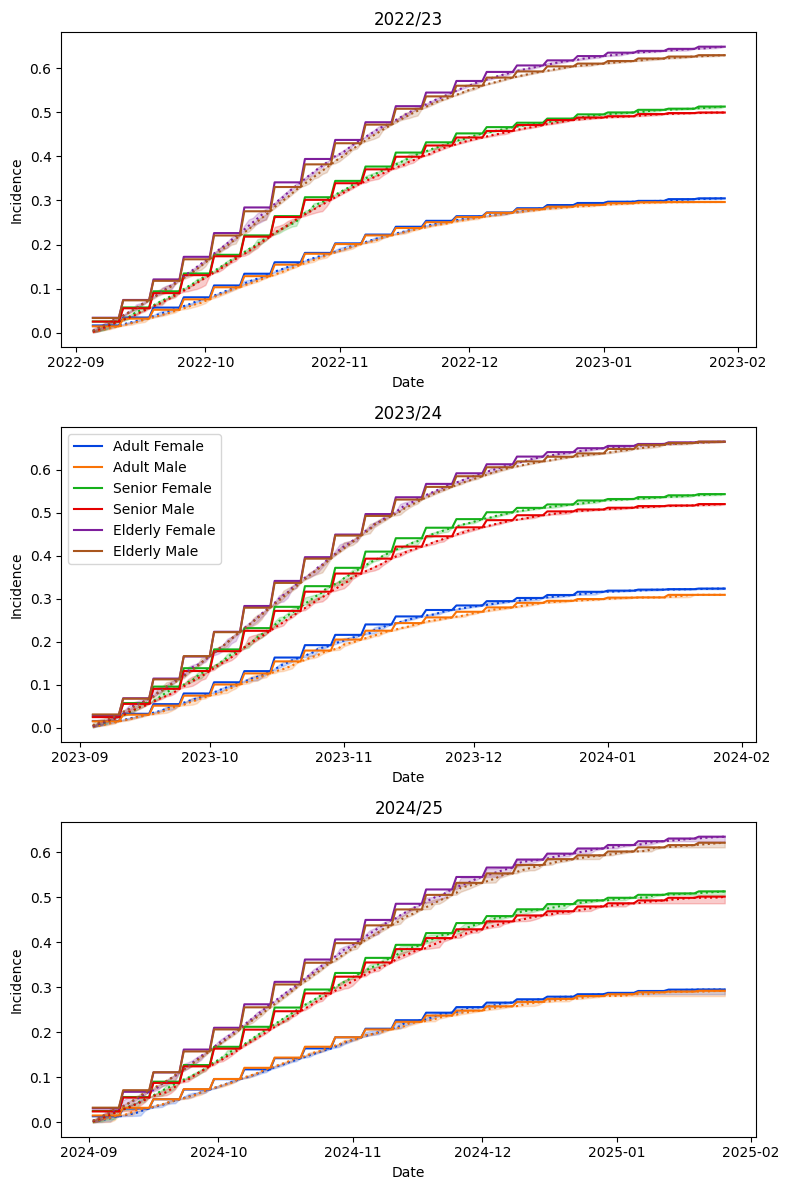

In [28]:
fig, axes = plt.subplots(
    nrows=len(season_ranges),
    ncols=1,
    figsize=(8, 12),
)

colors = (
    "xkcd:blue",
    "xkcd:orange",
    "xkcd:green",
    "xkcd:red",
    "xkcd:purple",
    "xkcd:sienna",
)
colors_map = {
    hash((age_category, sex_category)): color
    for color, (age_category, sex_category) in zip(
        colors, product(age_cov.categories, sex_cov.categories)
    )
}

for i, season_range in enumerate(season_ranges):
    ax = axes[i]
    ax.set_title(season_range.season)
    ax.set_xlabel("Date")
    ax.set_ylabel("Incidence")
    for age_category in age_cov.categories:
        for sex_category in sex_cov.categories:
            color = colors_map[hash((age_category, sex_category))]
            observations_subset = observations_prevalence[
                (observations_prevalence["season"] == season_range.season)
                & (observations_prevalence["age"] == age_category)
                & (observations_prevalence["sex"] == sex_category)
            ]
            x = [
                el
                for pair in zip(
                    observations_subset["start_date"].tolist(),
                    observations_subset["end_date"].tolist(),
                )
                for el in pair
            ]
            y = [
                el
                for pair in zip(
                    observations_subset["prevalence"].tolist(),
                    observations_subset["prevalence"].tolist(),
                )
                for el in pair
            ]
            ax.plot(
                x,
                y,
                label=f"{age_category.title()} {sex_category.title()}",
                color=color,
                linestyle="-",
            )

            summary_posterior_subset = prevalence_posterior_df[
                (prevalence_posterior_df["season"] == season_range.season)
                & (prevalence_posterior_df["age"] == age_category)
                & (prevalence_posterior_df["sex"] == sex_category)
            ]

            x = summary_posterior_subset["date"].tolist()
            y = summary_posterior_subset["median"].tolist()
            ax.plot(x, y, color=color, linestyle=":")

            y1 = summary_posterior_subset["lower"].tolist()
            y2 = summary_posterior_subset["upper"].tolist()
            ax.fill_between(x, y1, y2, color=color, alpha=0.2)
    if i == (len(season_ranges) // 2):
        ax.legend()

fig.tight_layout()
plt.show()

---